In [2]:
from config import settings
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_community.graphs import Neo4jGraph
from langchain_openai import ChatOpenAI

In [3]:
llm = ChatOpenAI(
    model="gpt-4o",
    api_key=settings.OPENAI_API_KEY,
)

llm_transformer = LLMGraphTransformer(llm=llm)

In [4]:
from IPython.display import Markdown, display

def display_markdown(text):
    """
    Display the given text in markdown format in a Jupyter notebook.

    Parameters:
    text (str): The text to be displayed in markdown format.
    """
    display(Markdown(text))

In [5]:
graph = Neo4jGraph(
    url=settings.NEO4J_URI,
    password=settings.NEO4J_PASSWORD,
    username=settings.NEO4J_USERNAME
)

In [6]:
from yfiles_jupyter_graphs import GraphWidget
from neo4j import GraphDatabase

default_cypher = "81`    "

def showGraph(cypher: str = default_cypher):
    driver = GraphDatabase.driver(
        uri = settings.NEO4J_URI,
        auth = (settings.NEO4J_USERNAME,
                settings.NEO4J_PASSWORD)
    )
    session = driver.session()
    widget = GraphWidget(graph = session.run(cypher).graph())
    widget.node_label_mapping = 'id'
    #display(widget)
    return widget

In [7]:
# Load data into the graph database using the dataloader
from data_loader import load_data_into_database

load_data_into_database()

showGraph()

GraphWidget(layout=Layout(height='800px', width='100%'))

In [8]:
from langchain_community.vectorstores import Neo4jVector
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small",
    api_key=settings.OPENAI_API_KEY,
)

vector_index = Neo4jVector.from_existing_graph(
    embeddings,
    search_type="hybrid",
    node_label="Document",
    text_node_properties=["text"],
    embedding_node_property="embedding",
    index_name = "document_embedding",
)

In [9]:
graph.query("""
  SHOW VECTOR INDEXES
  """
)

[{'id': 3,
  'name': 'document_embedding',
  'state': 'ONLINE',
  'populationPercent': 100.0,
  'type': 'VECTOR',
  'entityType': 'NODE',
  'labelsOrTypes': ['Document'],
  'properties': ['embedding'],
  'indexProvider': 'vector-2.0',
  'owningConstraint': None,
  'lastRead': None,
  'readCount': 0}]

##### Using GraphCypherQA


In [10]:
graph.refresh_schema()
graph.get_structured_schema

{'node_props': {'Person': [{'property': 'name', 'type': 'STRING'},
   {'property': 'age', 'type': 'INTEGER'},
   {'property': 'city', 'type': 'STRING'}],
  'Speaker': [{'property': 'id', 'type': 'STRING'},
   {'property': 'name', 'type': 'STRING'},
   {'property': 'biography', 'type': 'STRING'}],
  'Submission': [{'property': 'state', 'type': 'STRING'},
   {'property': 'submission_type', 'type': 'STRING'},
   {'property': 'location', 'type': 'STRING'},
   {'property': 'start_time', 'type': 'STRING'},
   {'property': 'duration', 'type': 'INTEGER'},
   {'property': 'end_time', 'type': 'STRING'},
   {'property': 'title', 'type': 'STRING'},
   {'property': 'abstract', 'type': 'STRING'},
   {'property': 'date', 'type': 'STRING'},
   {'property': 'description', 'type': 'STRING'},
   {'property': 'id', 'type': 'STRING'}],
  'Document': [{'property': 'id', 'type': 'STRING'},
   {'property': 'text', 'type': 'STRING'},
   {'property': 'embedding', 'type': 'LIST'}]},
 'rel_props': {'FRIEND': [{'p

In [11]:
from langchain_community.chains.graph_qa.cypher import GraphCypherQAChain

cypher_chain = GraphCypherQAChain.from_llm(graph=graph, llm=llm, verbose=True)
response = cypher_chain.invoke({"query": "How many submissions are there in total? Please group this submission into distinct talks and tutorials?"})
response



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (s:Submission)
RETURN s.submission_type AS type, COUNT(s) AS count

Full Context:
[{'type': 'Tutorial', 'count': 16}, {'type': 'Talk', 'count': 49}]

> Finished chain.


{'query': 'How many submissions are there in total? Please group this submission into distinct talks and tutorials?',
 'result': 'There are a total of 65 submissions, with 16 tutorials and 49 talks.'}

In [12]:
response = cypher_chain.invoke({"query": "What are the various locations where the conference is holding?"})
response



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (s:Submission)
RETURN DISTINCT s.location

Full Context:
[{'s.location': 'Warwick'}, {'s.location': 'Minories'}, {'s.location': 'Salisbury'}, {'s.location': 'Beaumont'}]

> Finished chain.


{'query': 'What are the various locations where the conference is holding?',
 'result': 'The conference is holding in Warwick, Minories, Salisbury, and Beaumont.'}

In [13]:
from langchain.chains.retrieval_qa.base import RetrievalQA

qa_graph_chain = RetrievalQA.from_chain_type(
    llm, retriever=vector_index.as_retriever(), verbose = True
)

result = qa_graph_chain.invoke({"query": "Where and when is the talk about Graph database holding? Who is the speaker?"})
result["result"]



> Entering new RetrievalQA chain...

> Finished chain.


'The talk about Graph databases, titled "Graph databases and Retrieval Augmented Generation," is scheduled to be held at Minories on 2024-06-14 from 13:30:00 to 15:00:00. The speaker for this tutorial is Kehinde Richard Ogunyale.'

In [14]:
from langchain.agents import AgentExecutor, create_react_agent
from langchain.tools import Tool
from langchain import hub
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_community.chat_message_histories import Neo4jChatMessageHistory

tools = [
    Tool.from_function(
        name="Cypher Chain",
        description="For when you need to answer questions that can be answered by directly querying the database without having to use knowledge of vector embeddings. The question will be a string. Return a string.",
        func=cypher_chain.invoke,
    ),

    Tool.from_function(
        name="Natural QA Chain",
        description="For answering text based questions that are not easy or straight-forward to answer using Cypher queries but can be answered using vector embeddings. The question will be a String. Return a String",
        func=qa_graph_chain.invoke
    )
]


def get_memory(session_id):
    return Neo4jChatMessageHistory(session_id=session_id, graph=graph)


agent_prompt = hub.pull("hwchase17/react-chat")
agent = create_react_agent(llm, tools, agent_prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, handle_parsing_errors=True)

chat_agent = RunnableWithMessageHistory(
    agent_executor,
    get_memory,
    input_messages_key="input",
    history_messages_key="chat_history",
)

In [16]:
question = "I am a software engineer and I would like to learn more about graph databases and retrieval augmented generation, which talk should I attend?"
response = chat_agent.invoke(
    {
        "input": question
    },
    {"configurable": {"session_id": "random_id"}},
)
response['output']

'If you provide me with the schedule or list of talks available at the conference or event you are attending, I can help you identify the most relevant sessions to attend based on your interest in graph databases and retrieval augmented generation. This way, I can give you specific recommendations tailored to your needs.'

#### Load more data

In [24]:
from langchain_core.documents import Document
from data_loader import scrape_website, ScrapedWebsite, generate_md5_hash
from langchain.text_splitter import TokenTextSplitter
from tqdm import tqdm

list_of_websites = ["https://pydata.org/london2024", "https://pydata.org/london2024/about",
                    "https://pydata.org/london2024/job-board", "https://pydata.org/london2024/humble", "https://pydata.org/london2024/sponsor"]

scraped_data: list[ScrapedWebsite] = [scrape_website(url) for url in tqdm(list_of_websites, desc="Scraping website")]
list_of_documents: list[Document] = [
    Document(
        page_content=data.content,
        metadata={"title": data.title,
                  "url": data.url,
                  "id": generate_md5_hash(data.content)
                  })
    for data in tqdm(scraped_data, desc="Processing documents")]

text_splitter = TokenTextSplitter(chunk_size=1024, chunk_overlap=24)
documents = text_splitter.split_documents(list_of_documents)

print(documents)

Processing documents: 100%|██████████| 5/5 [00:00<00:00, 2823.31it/s]


[Document(page_content='![Image 1](https://images.squarespace-cdn.com/content/v1/655270d4c839892af01aaf02/6a9c721d-5397-4349-a711-befa4be34f62/AdobeStock_132796360-dark.jpg)\n\nWHAT TO EXPECT\n--------------\n\nPyData London 2024 is a 3-day in-person event for the international community of data scientists, data engineers, and developers of data analysis tools to share ideas and learn from each other.\n\nDuring the conference, attendees will have the opportunity to attend live keynote sessions and talks, lightning talks, and get to know fellow members of the **Py****Data** Community.\n\n![Image 2](https://images.squarespace-cdn.com/content/v1/655270d4c839892af01aaf02/1699901673377-62BKP9F0DZ91L3D8PA26/promo+photo+with+overlay+1+-+small.png)\n\n![Image 3](https://images.squarespace-cdn.com/content/v1/655270d4c839892af01aaf02/d033c077-464f-4609-a990-4d841fe3b98f/magicpattern-mesh-gradient-1705596178730.png)\n\n**The event will be in-person at the** [**Leonardo Royal Hotel London Tower Br

Please uncomment the code below to run the LLMGraphTransformer. This transforms raw text into graph document.

In [25]:
# graph_documents = llm_transformer.convert_to_graph_documents(documents)
# 
# print(f"Graph Documents: {graph_documents}")

Graph Documents: [GraphDocument(nodes=[Node(id='Pydata London 2024', type='Event'), Node(id='Data Scientists', type='Group'), Node(id='Data Engineers', type='Group'), Node(id='Developers Of Data Analysis Tools', type='Group'), Node(id='Leonardo Royal Hotel London Tower Bridge', type='Location'), Node(id='Dr. Rebecca Bilbro', type='Person'), Node(id='Yellowbrick', type='Software'), Node(id='Rotational Labs', type='Organization'), Node(id='University Of Illinois, Urbana-Champaign', type='Organization')], relationships=[Relationship(source=Node(id='Pydata London 2024', type='Event'), target=Node(id='Data Scientists', type='Group'), type='INCLUDES'), Relationship(source=Node(id='Pydata London 2024', type='Event'), target=Node(id='Data Engineers', type='Group'), type='INCLUDES'), Relationship(source=Node(id='Pydata London 2024', type='Event'), target=Node(id='Developers Of Data Analysis Tools', type='Group'), type='INCLUDES'), Relationship(source=Node(id='Pydata London 2024', type='Event'),

In [26]:
# import pickle
# 
# with open("data/graph_documents.pkl", "wb") as f:
#     pickle.dump(graph_documents, f)

In [17]:
import pickle
with open("data/graph_documents.pkl", "rb") as f:
    graph_documents = pickle.load(f)

In [27]:
graph_documents

[GraphDocument(nodes=[Node(id='Pydata London 2024', type='Event'), Node(id='Data Scientists', type='Group'), Node(id='Data Engineers', type='Group'), Node(id='Developers Of Data Analysis Tools', type='Group'), Node(id='Leonardo Royal Hotel London Tower Bridge', type='Location'), Node(id='Dr. Rebecca Bilbro', type='Person'), Node(id='Yellowbrick', type='Software'), Node(id='Rotational Labs', type='Organization'), Node(id='University Of Illinois, Urbana-Champaign', type='Organization')], relationships=[Relationship(source=Node(id='Pydata London 2024', type='Event'), target=Node(id='Data Scientists', type='Group'), type='INCLUDES'), Relationship(source=Node(id='Pydata London 2024', type='Event'), target=Node(id='Data Engineers', type='Group'), type='INCLUDES'), Relationship(source=Node(id='Pydata London 2024', type='Event'), target=Node(id='Developers Of Data Analysis Tools', type='Group'), type='INCLUDES'), Relationship(source=Node(id='Pydata London 2024', type='Event'), target=Node(id='

In [18]:
from modified_neo4j_graph import ModifiedNeo4JGraph
graph = ModifiedNeo4JGraph(
    url=settings.NEO4J_URI,
    password=settings.NEO4J_PASSWORD,
    username=settings.NEO4J_USERNAME
)
graph.add_graph_documents_with_embeddings(
    graph_documents=graph_documents,
    baseEntityLabel=True,
    include_source=True,
    embedding=embeddings
)

In [19]:
from typing import Callable

def get_chat_agent(cypher_chain: Callable, qa_graph_chain: Callable) -> Callable:
    tools = [
        Tool.from_function(
            name="Cypher Chain",
            description="For when you need to answer questions that can be answered by directly querying the database without having to use knowledge of vector embeddings. The question will be a string. Return a string.",
            func=cypher_chain.invoke,
        ),
    
        Tool.from_function(
            name="Natural QA Chain",
            description="For answering text based questions that are not easy or straight-forward to answer using Cypher queries but can be answered using vector embeddings. The question will be a String. Return a String",
            func=qa_graph_chain.invoke
        )
    ]
    
    agent_prompt = hub.pull("hwchase17/react-chat")
    agent = create_react_agent(llm, tools, agent_prompt)
    agent_executor = AgentExecutor(agent=agent, tools=tools, handle_parsing_errors=True)
    
    chat_agent = RunnableWithMessageHistory(
        agent_executor,
        get_memory,
        input_messages_key="input",
        history_messages_key="chat_history",
    )
    
    return chat_agent
    

def get_memory(session_id):
    return Neo4jChatMessageHistory(session_id=session_id, graph=graph)


In [30]:
vector_index_without_retrieval_query = Neo4jVector.from_existing_graph(
    embeddings,
    search_type="hybrid",
    node_label="Document",
    text_node_properties=["text"],
    embedding_node_property="embedding",
    index_name = "document_embedding",
)

In [38]:
qa_graph_chain_without_retrieval_query = RetrievalQA.from_chain_type(
    llm, retriever=vector_index_without_retrieval_query.as_retriever(), verbose = True
)

result = qa_graph_chain.invoke({"query": "Who are the keynote speakers?"})
display_markdown(result["result"])



> Entering new RetrievalQA chain...

> Finished chain.


The keynote speakers for the 2024 PyData Conference are:

1. **Tania Allard**
   - Talk Title: *Keynote-Tania Allard-The art of building and sustaining successful OSS tools and infrastructure*
   - Biography: Tania is the director of Quansight Labs, a director of the PSF (Python Software Foundation), and a member of the PyLadies Global Council. She is passionate about open source, its community, and building tools for developers and data scientists.

2. **Dr. Rebecca Bilbro**
   - Talk Title: *Keynote- Dr. Rebecca Bilbro- Mistakes were made | Data science ten years in*
   - Biography: Dr. Rebecca Bilbro is an applied AI/ML engineer, teacher, and author. She is the co-creator of Yellowbrick, co-founder, and CTO of Rotational Labs, and is known for her contributions to the data science and engineering communities. She earned her doctorate from the University of Illinois, Urbana-Champaign.

3. **Dr. Matthew Crooks**
   - Talk Title: *Keynote- Data: Faithful or Traitor?*
   - Biography: Dr. Matthew Crooks is a Data Scientist at the BBC, with a background in modelling cloud microphysics in weather and climate systems. He has worked on various projects at the BBC, including developing an adaptive learning algorithm for BBC Bitesize and focusing on marketing projects and causal inference.

In [39]:
chat_agent = get_chat_agent(cypher_chain,qa_graph_chain_without_retrieval_query)
question = "What are the keynote speakers talking about?"
response = chat_agent.invoke(
    {
        "input": question
    },
    {"configurable": {"session_id": "randomId"}},
)
display_markdown(result['result'])



> Entering new RetrievalQA chain...

> Finished chain.


The keynote speakers for the 2024 PyData Conference are:

1. **Tania Allard**
   - Talk Title: *Keynote-Tania Allard-The art of building and sustaining successful OSS tools and infrastructure*
   - Biography: Tania is the director of Quansight Labs, a director of the PSF (Python Software Foundation), and a member of the PyLadies Global Council. She is passionate about open source, its community, and building tools for developers and data scientists.

2. **Dr. Rebecca Bilbro**
   - Talk Title: *Keynote- Dr. Rebecca Bilbro- Mistakes were made | Data science ten years in*
   - Biography: Dr. Rebecca Bilbro is an applied AI/ML engineer, teacher, and author. She is the co-creator of Yellowbrick, co-founder, and CTO of Rotational Labs, and is known for her contributions to the data science and engineering communities. She earned her doctorate from the University of Illinois, Urbana-Champaign.

3. **Dr. Matthew Crooks**
   - Talk Title: *Keynote- Data: Faithful or Traitor?*
   - Biography: Dr. Matthew Crooks is a Data Scientist at the BBC, with a background in modelling cloud microphysics in weather and climate systems. He has worked on various projects at the BBC, including developing an adaptive learning algorithm for BBC Bitesize and focusing on marketing projects and causal inference.

In [40]:
vector_index_with_retrieval_query = Neo4jVector.from_existing_graph(
    embeddings,
    search_type="hybrid",
    node_label="Document",
    text_node_properties=["text"],
    embedding_node_property="embedding",
    index_name = "document_embedding",
    retrieval_query="""
    WITH node AS doc, score as similarity
    CALL {
        WITH doc
        MATCH (doc)-[*1..2]-(related)
        WITH doc, related, [key in keys(related) WHERE key <> 'embedding'] AS filtered_keys
        RETURN DISTINCT related, [key IN filtered_keys | key + ': ' + toString(related[key])] AS properties_list
    }
    WITH doc, similarity, properties_list
    RETURN coalesce(doc.text, '') + ' ' + coalesce(reduce(s = '', prop IN properties_list | s + ', ' + prop), '') AS text, similarity AS score, {source: doc.text} AS metadata
    LIMIT 25
    """
)

In [44]:
qa_graph_chain = RetrievalQA.from_chain_type(
    llm, retriever=vector_index_with_retrieval_query.as_retriever(), verbose = True
)

result = qa_graph_chain.invoke({"query": "Which speakers are software engineers? "})
display_markdown(result["result"])



> Entering new RetrievalQA chain...


RateLimitError: Error code: 429 - {'error': {'message': 'Request too large for gpt-4o in organization org-G56wgARiw4O8uuE2XCe2uHmw on tokens per min (TPM): Limit 30000, Requested 40230. The input or output tokens must be reduced in order to run successfully. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}

The above error is expected because in the retrieval query we are fetching more than enough context that we are passing to the LLM. Try reducing the limit in the retrieval query

In [34]:
# graph.refresh_schema()
# graph.get_structured_schema

{'node_props': {'Speaker': [{'property': 'id', 'type': 'STRING'},
   {'property': 'biography', 'type': 'STRING'},
   {'property': 'name', 'type': 'STRING'}],
  'Submission': [{'property': 'state', 'type': 'STRING'},
   {'property': 'title', 'type': 'STRING'},
   {'property': 'location', 'type': 'STRING'},
   {'property': 'start_time', 'type': 'STRING'},
   {'property': 'duration', 'type': 'INTEGER'},
   {'property': 'end_time', 'type': 'STRING'},
   {'property': 'submission_type', 'type': 'STRING'},
   {'property': 'abstract', 'type': 'STRING'},
   {'property': 'date', 'type': 'STRING'},
   {'property': 'description', 'type': 'STRING'},
   {'property': 'id', 'type': 'STRING'}],
  'Document': [{'property': 'id', 'type': 'STRING'},
   {'property': 'text', 'type': 'STRING'},
   {'property': 'embedding', 'type': 'LIST'}],
  'Event': [{'property': 'id', 'type': 'STRING'}],
  'Person': [{'property': 'id', 'type': 'STRING'}],
  'Location': [{'property': 'id', 'type': 'STRING'}],
  'Software':

In [45]:
SESSION_ID = "6bdabff3-2bb2-4f23-a696-e10435dc111de"
print(f"Session ID: {SESSION_ID}")

# while True:
q = input("> ")
print(f"Question: {q}")

response = chat_agent.invoke(
    {
        "input": q
    },
    {"configurable": {"session_id": SESSION_ID}},
)

print(f"Result: {response['output']}")

Session ID: 6bdabff3-2bb2-4f23-a696-e10435dc111de
Question: Which speaker is speaking about Graph database and where is the conference taking place?


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (s:Speaker)-[:PRESENTED]->(sub:Submission)-[:ON_LOCATION]->(loc:Submission)
WHERE sub.title CONTAINS "Graph database"
RETURN s.name, loc.location

Full Context:
[{'s.name': 'Kehinde Richard Ogunyale', 'loc.location': 'Minories'}, {'s.name': 'Kehinde Richard Ogunyale', 'loc.location': 'Minories'}, {'s.name': 'Kehinde Richard Ogunyale', 'loc.location': 'Minories'}, {'s.name': 'Kehinde Richard Ogunyale', 'loc.location': 'Minories'}, {'s.name': 'Kehinde Richard Ogunyale', 'loc.location': 'Minories'}, {'s.name': 'Kehinde Richard Ogunyale', 'loc.location': 'Minories'}, {'s.name': 'Kehinde Richard Ogunyale', 'loc.location': 'Minories'}, {'s.name': 'Kehinde Richard Ogunyale', 'loc.location': 'Minories'}, {'s.name': 'Kehinde Richard Ogunyale', 'loc.location': 'Minories'}, {

### Please Subscribe to my Newsletter

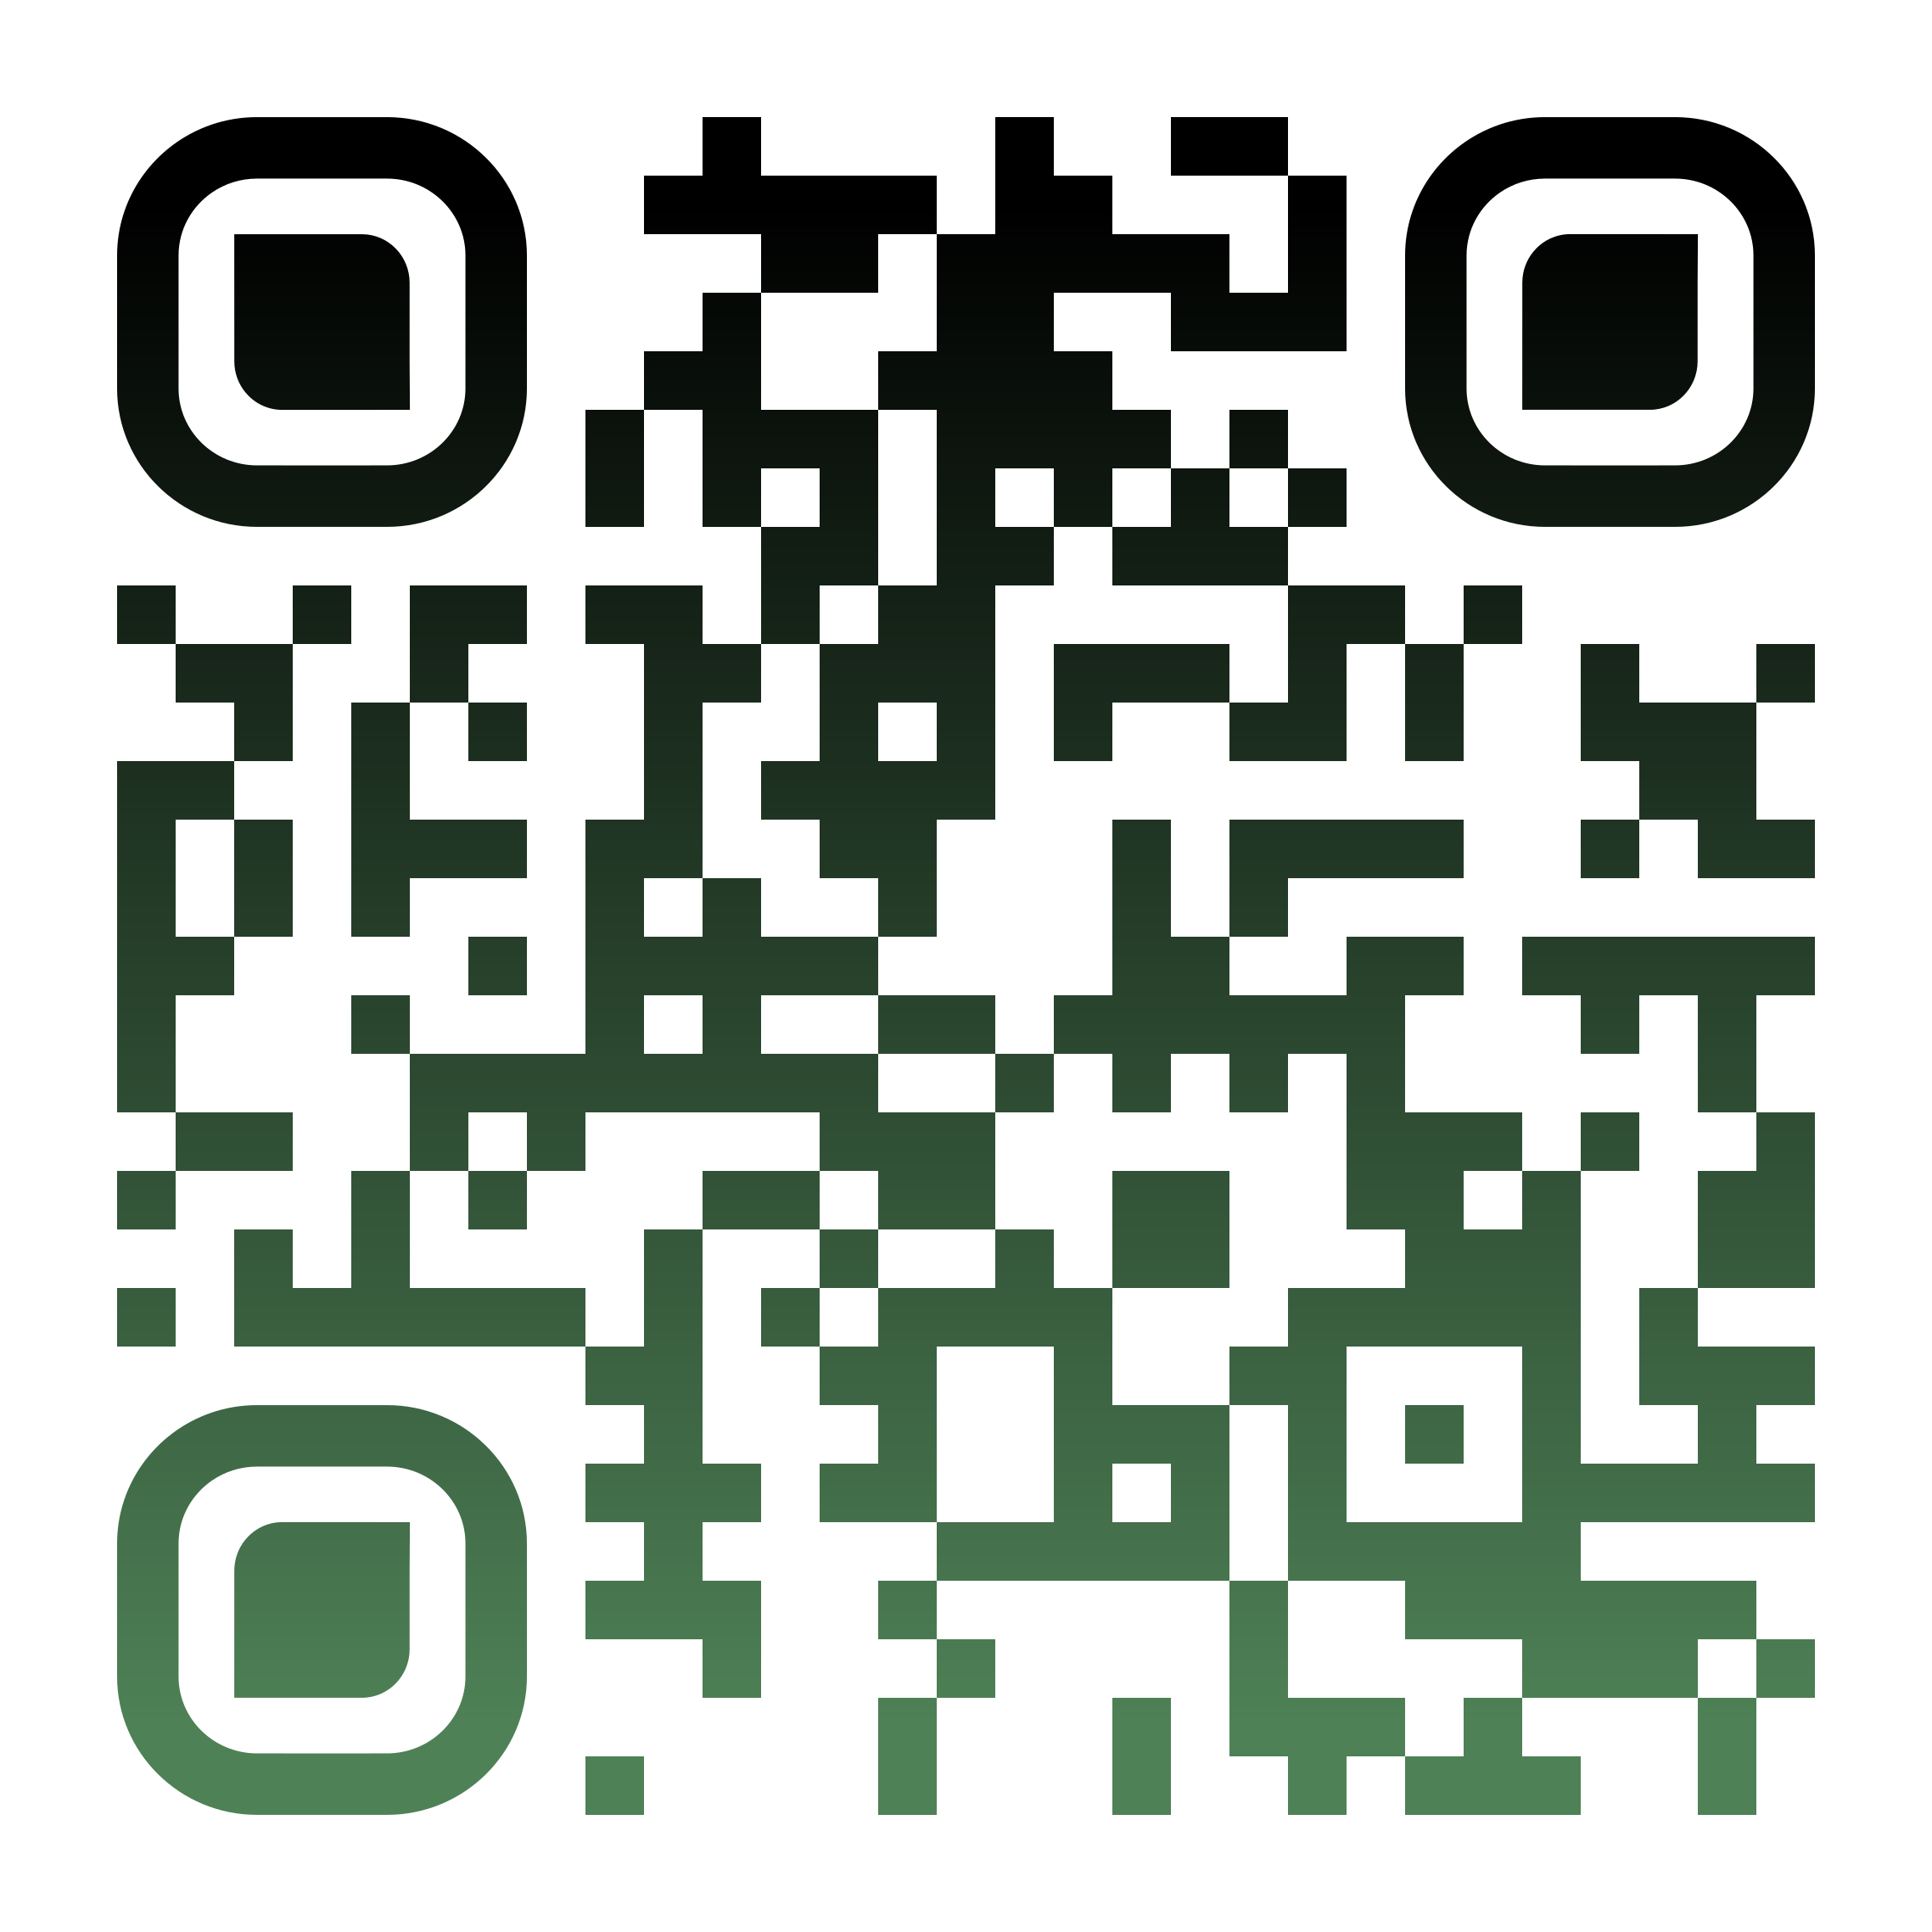

In [3]:
from IPython.display import Image, display

display(Image(filename='images/BeatByteNewsletter.png', width=400))